# 1. Importacion de librerias

In [44]:
import io
import re
import nltk
from main import initial_path
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from runs.rss_scraping import rss_scrap, urls
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from utils.text_analysis import TextAnalysis

In [6]:
DIR_PATH = initial_path('Es_News_report')

Found it


# 2. Obtención y descripción de los datos

In [8]:
data = pd.read_csv(DIR_PATH, sep=';')
data.head()

,title,content,type
0,Los elefantes que pensó Alexánder Robledo,Dice que le gustaría tener un contacto real co...,Cultura
1,Otra oportunidad para ver lo mejor de 2016,"- 17 años - Jericó, el infinito vuelo de los d...",Cultura
2,SENSACIÓN CREPUSCULAR,espera el milagroso esquila del rebaño venda...,Cultura
3,"Salen los jugadores, entran los directivos",La temporada que recién terminó para Nacional ...,Deportes
4,"Como sexta en el ranking de la Fifa, Colombia ...",11. Suiza 1129 Sudamérica conserva su ...,Deportes


## 2.1. Descripción del contenido

In [9]:
news_by_type = data.groupby("type", as_index=False)['content'].count()
news_by_type.head(10)

,type,content
0,Ciencia y Tecnologia,327
1,Cultura,324
2,Deportes,334
3,Economia,330
4,Salud,320


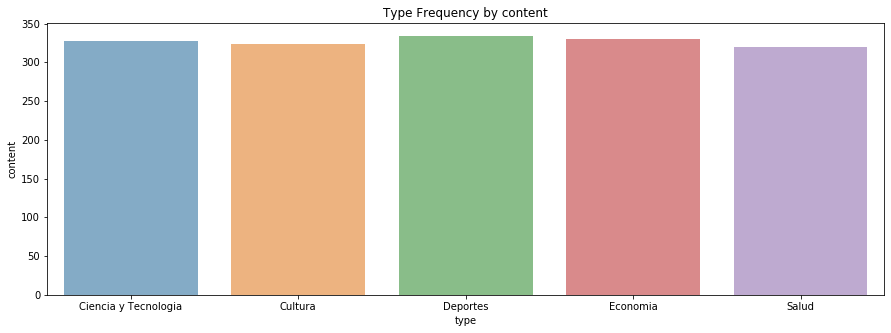

In [63]:
plt.figure(figsize=(15,5))
sns.barplot(news_by_type['type'].values, news_by_type['content'].values, alpha=0.6)
plt.title('Type Frequency by content')
plt.ylabel('content', fontsize=10)
plt.xlabel('type', fontsize=10)
plt.show()

In [31]:
data.dtypes

title      object
content    object
type       object
dtype: object

In [32]:
ta = TextAnalysis('es')
nltk.download('cess_esp')
words = set(nltk.corpus.cess_esp.words())

Language: es
Text Analysis: ['emoji', 'tagger', 'parser', 'stemmer', 'ner']


[nltk_data] Downloading package cess_esp to C:\Users\Jesus
[nltk_data]     Caraballo\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


# 3. Preprocesamiento de textos

In [33]:
setting = {'url': False, 'mention': False, 'emoji': False, 'hashtag': False, 'stopwords': True, 'relabel': False} 
content_list =  data['content'].to_list()
list_sentences = []
for row in tqdm(content_list):
    text = ta.clean_text(row, **setting)
    # Eliminando direcciones de correo
    text = re.sub('\S*@\S*\s?', '', text)
    # Eliminando palabras en ingles
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    list_sentences.append(text)

100%|██████████| 1635/1635 [01:46<00:00, 15.40it/s]


In [12]:
print('Text org: {0} \n\nTex clean: {1}'.format(content_list[1], list_sentences[1]))

Text org: - 17 años - Jericó, el infinito vuelo de los días Dos veces al año el Colombo Americano y la Revista Kinetoscopio hacen el recuento de lo Mejor del año, una selección que escoge una serie de películas que presentaron en cada semestre y que para el criterio sus expertos son lo más destacado. Para la selección, que la hace el departamento de cine de la Revista Kinetoscopio, tienen en cuenta la asistencia a las salas durante ese periodo, además de los reconocimientos y la participación en festivales internacionales.  - Julieta - Aislados Toda la programación tiene boletería 2x1. - Camino a Estambul - La chica del tren 
			Prohibida su reproducción total o parcial. La traducción a cualquier idioma está permitida estrictamente para usos pedagógicos y debe citarse la fuente. Reproduction in whole or in part is forbidden. Translation in any language is permitted strictly for pedagogic uses without written permission, and credits shoud be given to EL MUNDO.
      Webmaster: webmaster

In [34]:
x = list_sentences
y = data['type'].to_list()

In [35]:
print('**Replica y_train:', sorted(Counter(y).items()))

**Replica y_train: [('Ciencia y Tecnologia', 327), ('Cultura', 324), ('Deportes', 334), ('Economia', 330), ('Salud', 320)]


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=8675309)
print('**Replica train: {0}, size {1}'.format(sorted(Counter(y_train).items()), len(y_train)))
print('**Replica test: {0}, size {1}'.format(sorted(Counter(y_test).items()), len(y_test)))

**Replica train: [('Ciencia y Tecnologia', 230), ('Cultura', 227), ('Deportes', 252), ('Economia', 224), ('Salud', 211)], size 1144
**Replica test: [('Ciencia y Tecnologia', 97), ('Cultura', 97), ('Deportes', 82), ('Economia', 106), ('Salud', 109)], size 491


# Features in Bag of Words

In [37]:
vec = CountVectorizer(min_df=10, ngram_range=(1,3), max_features=5000, strip_accents='unicode', lowercase =True, analyzer='word')
vec.fit(x_train)
x_train = vec.transform(x_train)
x_test = vec.transform(x_test)

# Entrenamiento del modelo

In [47]:
classifier = LogisticRegression(C=10, penalty='l2', solver='newton-cg', multi_class='multinomial',max_iter=1000) 
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# Validación cruzada

In [48]:
cv_score = np.mean(cross_val_score(classifier, x_train, y_train, cv=5, scoring='accuracy'))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {}%'.format(round(accuracy, 2)*100))
print('Accuracy with CV: {}%'.format(round(cv_score, 2)*100))

Accuracy: 96.0%
Accuracy with CV: 95.0%


# Metricas de analítica predictiva


                      precision    recall  f1-score   support

Ciencia y Tecnologia       0.98      0.96      0.97        97
             Cultura       0.91      0.94      0.92        97
            Deportes       0.95      0.99      0.97        82
            Economia       0.96      0.98      0.97       106
               Salud       0.97      0.92      0.94       109

            accuracy                           0.96       491
           macro avg       0.96      0.96      0.96       491
        weighted avg       0.96      0.96      0.96       491

1:Ciencia y Tecnologia 2:Cultura 3:Deportes 4:Economia 5:Salud


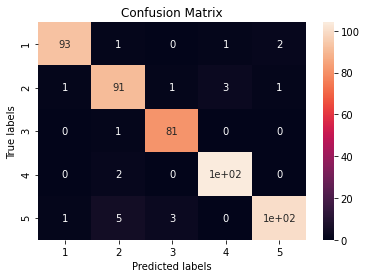

In [49]:
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5' ]); ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5']);
print("")
print(classification_report(y_test, y_pred))
print('1:Ciencia y Tecnologia','','2:Cultura', '3:Deportes', '4:Economia', '5:Salud')

In [50]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy: {}%'.format(round(accuracy, 2)*100))
print('Recall: {}%'.format(round(recall, 2)*100))
print('Precision: {}%'.format(round(precision, 2)*100))
print('F1: {}%'.format(round(f1, 2)*100))

Accuracy: 96.0%
Recall: 96.0%
Precision: 96.0%
F1: 96.0%
